In [1]:
from PIL import Image
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import tensorflow as tf
import keras
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Conv2D,Flatten,Dropout,MaxPooling2D,Activation, BatchNormalization, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from keras.optimizers import *
from keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2
import matplotlib.pyplot as plt
import cv2

Using TensorFlow backend.


<h3>Data exploration

In [2]:
# reading first five rows of the dataset
training_data = pd.read_csv('./data/train.csv')
training_data.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [3]:
# counting total number of entries
training_data.has_cactus.count()

17500

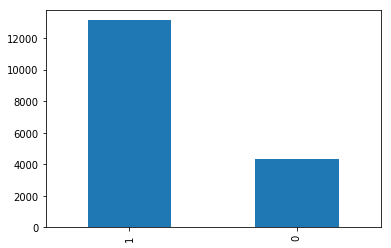

In [4]:
# plot training set according to has_cactus value
training_data['has_cactus'].value_counts().plot(kind='bar')

In [5]:
# get exact count of has_cactus in training set
training_data['has_cactus'].value_counts()

1    13136
0     4364
Name: has_cactus, dtype: int64

<h3>Image Loading Routine

In [6]:
def load_images(path):
    images = {}
    for file in os.listdir(path):
        filename = os.path.join(path, file)
        images[file] = cv2.imread(filename)
    return images

training_images = load_images('./data/train')
testing_images = load_images('./data/test')

def create_train_set():
    X_train = []
    Y_train = []

    for _, row in training_data.iterrows():
        X_train.append(training_images[row['id']])
        Y_train.append(int(row['has_cactus']))

    X_train = np.array(X_train)
    Y_train = np.array(Y_train)
    return X_train, Y_train

def create_test_set():
    X_test = np.array([testing_images[f] for f in testing_images])
    return X_test

X_train, Y_train = create_train_set()
X_test = create_test_set()

print('X_train shape: ', X_train.shape)
print('Y_train shape: ', Y_train.shape)

X_train shape:  (17500, 32, 32, 3)
Y_train shape:  (17500,)


<h3> Model creation functions
   

In [7]:
# function that takes as input a model and adds a convolutional layer to it
def add_layer(model, **args):
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', **args))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D())

In [8]:
# function that takes as input a number of levels of convolutional layers, and creates a model
def build_model(num_layers = 1):
    model = Sequential()
    
    for i in range(num_layers):
        if i:
            add_layer(model)
        else:
            add_layer(model, input_shape=(32,32,3))
    
    model.add(Flatten())
    
    model.add(Dropout(0.4))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

<h3> Benchmark model

In [9]:
# create model and check its summary
benchmark_model = build_model()
benchmark_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dropout_1 (Dropout)  

In [10]:
# compile the model (using crossentropy as loss function)
benchmark_model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [11]:
random_indexes = np.random.permutation(17500)

x_train = X_train[random_indexes[:7500]]
y_train = Y_train[random_indexes[:7500]]

x_valid = X_train[random_indexes[7500:]]
y_valid = Y_train[random_indexes[7500:]]

In [12]:
benchmark_model.fit(x_train, y_train, epochs = 1, batch_size = 8, validation_data = (x_valid, y_valid))

Instructions for updating:
Use tf.cast instead.
Train on 7500 samples, validate on 10000 samples
Epoch 1/1
7500/7500 [==============================] - 16s 2ms/step - loss: 0.2098 - acc: 0.9307 - val_loss: 0.2515 - val_acc: 0.9155


In [13]:
benchmark_model.save('benchmark_model.h5')

<h3>Intermediate model 1: 1 extra layer, epochs = 4, batch_size = 16</h3><br>
From this step ownards, the validation data will contain 11500 entries
    

In [14]:
random_indexes = np.random.permutation(17500)

x_train = X_train[random_indexes[:11500]]
y_train = Y_train[random_indexes[:11500]]

x_valid = X_train[random_indexes[11500:]]
y_valid = Y_train[random_indexes[11500:]]

In [15]:
intermediate_model_1 = build_model(num_layers = 2)
intermediate_model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
batch_normalization_3 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
activation_3 (Activation)    (None, 16, 16, 64)        0         
__________

In [16]:
intermediate_model_1.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [17]:
intermediate_model_1.fit(x_train, y_train, epochs = 4, batch_size = 16, validation_data = (x_valid, y_valid))

Train on 11500 samples, validate on 6000 samples
Epoch 1/4
11500/11500 [==============================] - 22s 2ms/step - loss: 0.1662 - acc: 0.9397 - val_loss: 0.0893 - val_acc: 0.9665
Epoch 2/4
11500/11500 [==============================] - 22s 2ms/step - loss: 0.1013 - acc: 0.9640 - val_loss: 0.0607 - val_acc: 0.9770
Epoch 3/4
11500/11500 [==============================] - 22s 2ms/step - loss: 0.0770 - acc: 0.9727 - val_loss: 0.1694 - val_acc: 0.9487
Epoch 4/4
11500/11500 [==============================] - 22s 2ms/step - loss: 0.0678 - acc: 0.9764 - val_loss: 0.0694 - val_acc: 0.9757


In [78]:
intermediate_model_1.save('intermediate_model_1.h5')

<h3>Intermediate model 2: 2 extra layers, epochs = 16, batch_size = 32</h3><br>

In [79]:
intermediate_model_2 = build_model(num_layers = 3)
intermediate_model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_28 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_28 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
batch_normalization_29 (Batc (None, 16, 16, 64)        256       
_________________________________________________________________
activation_29 (Activation)   (None, 16, 16, 64)        0         
__________

In [80]:
intermediate_model_2.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [81]:
intermediate_model_2.fit(x_train, y_train, epochs = 16, batch_size = 32, validation_data = (x_valid, y_valid))

Train on 11500 samples, validate on 6000 samples
Epoch 1/16
11500/11500 [==============================] - 24s 2ms/step - loss: 0.1666 - acc: 0.9343 - val_loss: 0.1071 - val_acc: 0.9570
Epoch 2/16
11500/11500 [==============================] - 23s 2ms/step - loss: 0.0847 - acc: 0.9681 - val_loss: 0.0787 - val_acc: 0.9707
Epoch 3/16
11500/11500 [==============================] - 23s 2ms/step - loss: 0.0708 - acc: 0.9709 - val_loss: 0.0481 - val_acc: 0.9827
Epoch 4/16
11500/11500 [==============================] - 22s 2ms/step - loss: 0.0594 - acc: 0.9783 - val_loss: 0.1365 - val_acc: 0.9520
Epoch 5/16
11500/11500 [==============================] - 22s 2ms/step - loss: 0.0471 - acc: 0.9826 - val_loss: 0.0611 - val_acc: 0.9795
Epoch 6/16
11500/11500 [==============================] - 22s 2ms/step - loss: 0.0392 - acc: 0.9854 - val_loss: 0.0413 - val_acc: 0.9848
Epoch 7/16
11500/11500 [==============================] - 22s 2ms/step - loss: 0.0377 - acc: 0.9857 - val_loss: 0.0283 - val_acc:

<h3> Accuracy target accomplished. Final training and predictions</h3>
We have reached 99% accuracy, so we will save this as the final model, train it on the full dataset, and make predictions

In [19]:
final_model = build_model(num_layers = 3)

final_model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

final_model.fit(X_train, Y_train, epochs=16, batch_size=32)

final_model.save('final_model.h5')

Epoch 1/16
17500/17500 [==============================] - 33s 2ms/step - loss: 0.1479 - acc: 0.9404
Epoch 2/16
17500/17500 [==============================] - 32s 2ms/step - loss: 0.0738 - acc: 0.9731
Epoch 3/16
17500/17500 [==============================] - 33s 2ms/step - loss: 0.0555 - acc: 0.9801
Epoch 4/16
17500/17500 [==============================] - 32s 2ms/step - loss: 0.0445 - acc: 0.9834
Epoch 5/16
17500/17500 [==============================] - 32s 2ms/step - loss: 0.0358 - acc: 0.9872
Epoch 6/16
17500/17500 [==============================] - 32s 2ms/step - loss: 0.0291 - acc: 0.9903
Epoch 7/16
17500/17500 [==============================] - 32s 2ms/step - loss: 0.0247 - acc: 0.9905
Epoch 8/16
17500/17500 [==============================] - 32s 2ms/step - loss: 0.0235 - acc: 0.9913
Epoch 9/16
17500/17500 [==============================] - 32s 2ms/step - loss: 0.0211 - acc: 0.9927
Epoch 10/16
17500/17500 [==============================] - 32s 2ms/step - loss: 0.0201 - acc: 0.9929

In [22]:
# create an output file with predictions
pred = final_model.predict(X_test)


df = pd.DataFrame({
    'id': [f for f in testing_images],
    'has_cactus': [int(x[0] > 0.5) for x in pred]
})

df.to_csv('predictions.csv', index=False)

In [83]:
final_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_31 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_31 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
batch_normalization_32 (Batc (None, 16, 16, 64)        256       
_________________________________________________________________
activation_32 (Activation)   (None, 16, 16, 64)        0         
__________